In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [4]:
lines = spark.read.text("/content/drive/MyDrive/ml-1m/ratings.dat").rdd

In [5]:
parts = lines.map(lambda x: x.value.split("::"))

In [6]:
ratingsRDD = parts.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),
                                     rating=float(p[2])))

In [7]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

In [8]:
ratings = spark.createDataFrame(ratingsRDD)

In [9]:
ratings.collect()

[Row(userId=1, movieId=1193, rating=5.0),
 Row(userId=1, movieId=661, rating=3.0),
 Row(userId=1, movieId=914, rating=3.0),
 Row(userId=1, movieId=3408, rating=4.0),
 Row(userId=1, movieId=2355, rating=5.0),
 Row(userId=1, movieId=1197, rating=3.0),
 Row(userId=1, movieId=1287, rating=5.0),
 Row(userId=1, movieId=2804, rating=5.0),
 Row(userId=1, movieId=594, rating=4.0),
 Row(userId=1, movieId=919, rating=4.0),
 Row(userId=1, movieId=595, rating=5.0),
 Row(userId=1, movieId=938, rating=4.0),
 Row(userId=1, movieId=2398, rating=4.0),
 Row(userId=1, movieId=2918, rating=4.0),
 Row(userId=1, movieId=1035, rating=5.0),
 Row(userId=1, movieId=2791, rating=4.0),
 Row(userId=1, movieId=2687, rating=3.0),
 Row(userId=1, movieId=2018, rating=4.0),
 Row(userId=1, movieId=3105, rating=5.0),
 Row(userId=1, movieId=2797, rating=4.0),
 Row(userId=1, movieId=2321, rating=3.0),
 Row(userId=1, movieId=720, rating=3.0),
 Row(userId=1, movieId=1270, rating=5.0),
 Row(userId=1, movieId=527, rating=5.0),


In [10]:
(training, test) = ratings.randomSplit([0.8, 0.2])

In [11]:
test

userId,movieId,rating
1,588,4.0
1,608,4.0
1,745,3.0
1,1287,5.0
1,1721,4.0
1,1961,5.0
1,2340,3.0
1,2398,4.0
1,2791,4.0
1,2804,5.0


In [12]:
als = ALS(maxIter=5, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

In [13]:
# Access user factors and item factors DataFrames
user_factors = model.userFactors
item_factors = model.itemFactors

# Show the first few rows to view the factors
user_factors.show()
item_factors.show()

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.5172266, -0.04...|
| 20|[0.28896508, 0.55...|
| 30|[0.08376678, 0.43...|
| 40|[0.2746705, 0.468...|
| 50|[-0.07897154, 0.0...|
| 60|[-0.5709197, -0.2...|
| 70|[0.88458556, 0.34...|
| 80|[-0.13095067, 0.0...|
| 90|[0.5450023, -0.06...|
|100|[0.060193967, 0.4...|
|110|[-0.08155082, 0.5...|
|120|[0.3277926, 0.680...|
|130|[0.5497915, 0.144...|
|140|[0.5817776, 0.718...|
|150|[0.16073973, 0.45...|
|160|[0.053390447, 0.1...|
|170|[0.032960773, 0.8...|
|180|[0.05579817, 0.59...|
|190|[0.2541073, 0.363...|
|200|[0.36570293, 0.21...|
+---+--------------------+
only showing top 20 rows

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.13404764, -0.1...|
| 20|[-0.035042085, -0...|
| 30|[0.23001388, 0.07...|
| 40|[0.015934855, 0.3...|
| 50|[0.012069447, 0.2...|
| 60|[-0.0728467, 0.00...|
| 70|[0.5193867, 0.065...|
| 80|[-0.25393283, 0.3...|
| 90|[-0.16406403, 0.3...|
|1

In [14]:
type(user_factors)

pyspark.sql.dataframe.DataFrame

In [15]:
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [16]:
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.8941120719180715


In [17]:
predictions.describe()

summary,userId,movieId,rating,prediction
count,200377,200377,200377,200377
mean,3028.7688008104724,1869.4513242537816,3.583699726016459,3.3464044112471254
stddev,1729.508749020037,1095.2025473183076,1.1171285534620667,0.6477279088567228
min,1,1,1.0,-0.9389508
max,6040,3952,5.0,5.464183


In [18]:
test.describe()

summary,userId,movieId,rating
count,200423,200423,200423
mean,3028.708845791152,1869.5188027322213,3.583540811184345
stddev,1729.5097969567137,1095.2322223320934,1.1171578019509012
min,1,1,1.0
max,6040,3952,5.0


In [19]:
output_path = "als.csv"
# Repartition the DataFrame into a single partition
df_single_partition = predictions.coalesce(1)

# Write the single-partition DataFrame to a CSV file
df_single_partition.write.csv(output_path, header=True, mode='overwrite')

In [20]:
predictions.count()

200377

In [21]:
predictions

userId,movieId,rating,prediction
3184,148,4.0,3.378334
1242,148,3.0,2.7581484
1605,148,2.0,2.1193135
840,148,1.0,2.9952784
1150,148,2.0,2.5563385
424,148,4.0,2.651739
3053,148,3.0,2.7773268
3151,463,5.0,3.6111734
4277,463,4.0,3.152972
3808,463,3.0,2.2435718


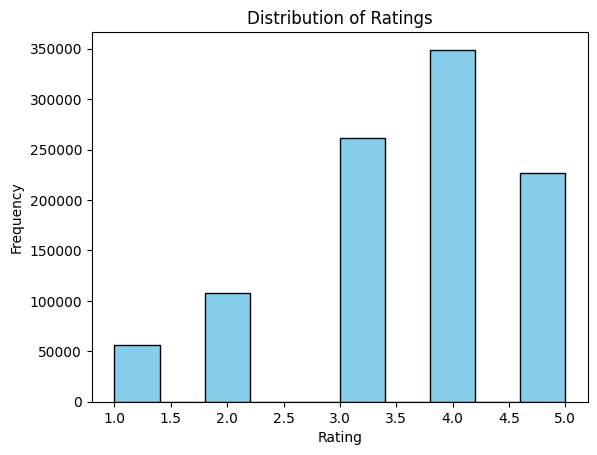

In [22]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame for visualization
ratings_pd = ratings.toPandas()

# Plot histogram of ratings
plt.hist(ratings_pd['rating'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()


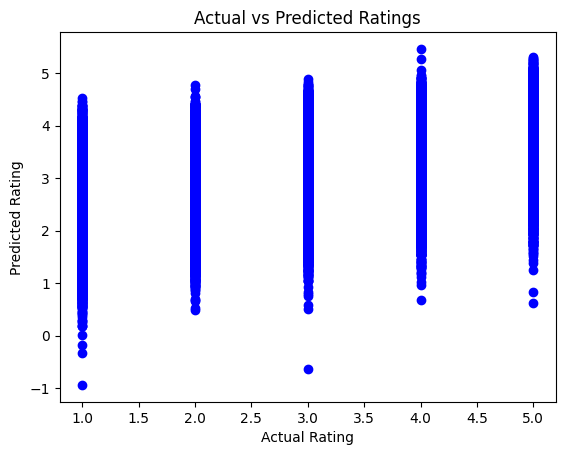

In [23]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
predictions_pd = predictions.toPandas()

# Plot actual vs predicted ratings
plt.scatter(predictions_pd['rating'], predictions_pd['prediction'], color='blue')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted Ratings')
plt.show()


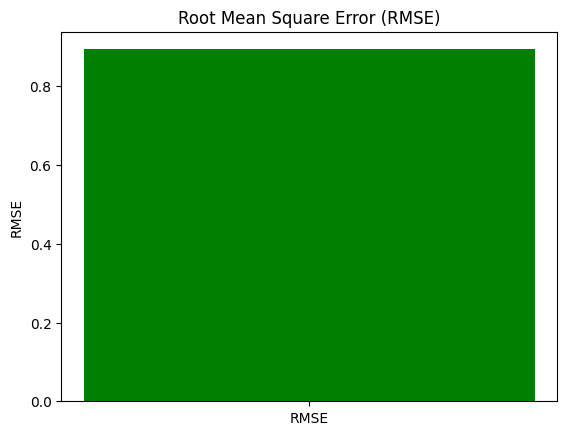

In [24]:
# Plot RMSE
plt.bar(['RMSE'], [rmse], color='green')
plt.ylabel('RMSE')
plt.title('Root Mean Square Error (RMSE)')
plt.show()